In [3]:
#!pip install pandas numpy matplotlib yfinance scipy

# Importação das bibliotecas necessárias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
from scipy.optimize import minimize

# Funções auxiliares
def get_data(tickers, start_date, end_date):
    return yf.download(tickers, start=start_date, end=end_date)['Adj Close']

# Coleta de dados históricos de preços
tickers = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'TSLA']
data = get_data(tickers, '2020-01-01', '2023-01-01')
print(data)

[*********************100%%**********************]  5 of 5 completed

Ticker            AAPL       AMZN      GOOGL        MSFT        TSLA
Date                                                                
2020-01-02   73.059418  94.900497  68.355545  154.215698   28.684000
2020-01-03   72.349136  93.748497  67.997955  152.295410   29.534000
2020-01-06   72.925629  95.143997  69.810379  152.689087   30.102667
2020-01-07   72.582657  95.343002  69.675537  151.296921   31.270666
2020-01-08   73.750252  94.598503  70.171463  153.706772   32.809334
...                ...        ...        ...         ...         ...
2022-12-23  130.959961  85.250000  89.127708  235.769760  123.150002
2022-12-27  129.142456  83.040001  87.289818  234.021713  109.099998
2022-12-28  125.179680  81.820000  85.921387  231.621841  112.709999
2022-12-29  128.725311  84.180000  88.348602  238.021500  121.820000
2022-12-30  129.043121  84.000000  88.128860  236.846252  123.180000

[756 rows x 5 columns]


In [4]:
def calculate_returns(prices):
    return prices.pct_change().dropna()

# Cálculo dos retornos diários
returns = calculate_returns(data)
print(returns)

Ticker          AAPL      AMZN     GOOGL      MSFT      TSLA
Date                                                        
2020-01-03 -0.009722 -0.012139 -0.005231 -0.012452  0.029633
2020-01-06  0.007968  0.014886  0.026654  0.002585  0.019255
2020-01-07 -0.004703  0.002092 -0.001932 -0.009118  0.038801
2020-01-08  0.016086 -0.007809  0.007118  0.015928  0.049205
2020-01-09  0.021241  0.004799  0.010498  0.012493 -0.021945
...              ...       ...       ...       ...       ...
2022-12-23 -0.002798  0.017425  0.016750  0.002267 -0.017551
2022-12-27 -0.013878 -0.025924 -0.020621 -0.007414 -0.114089
2022-12-28 -0.030685 -0.014692 -0.015677 -0.010255  0.033089
2022-12-29  0.028324  0.028844  0.028249  0.027630  0.080827
2022-12-30  0.002469 -0.002138 -0.002487 -0.004938  0.011164

[755 rows x 5 columns]


In [6]:
# Análise de desempenho
mean_returns = returns.mean() * 252
cov_matrix = returns.cov() * 252
risk_free_rate = 0.01

print(mean_returns)
print(cov_matrix)

Ticker
AAPL     0.258011
AMZN     0.035559
GOOGL    0.144413
MSFT     0.203655
TSLA     0.747064
dtype: float64
Ticker      AAPL      AMZN     GOOGL      MSFT      TSLA
Ticker                                                  
AAPL    0.136407  0.095733  0.093136  0.104155  0.138480
AMZN    0.095733  0.152759  0.091682  0.095278  0.134639
GOOGL   0.093136  0.091682  0.119187  0.099620  0.112748
MSFT    0.104155  0.095278  0.099620  0.120806  0.125667
TSLA    0.138480  0.134639  0.112748  0.125667  0.521113


In [9]:
def portfolio_performance(weights, returns):
    portfolio_return = np.sum(returns.mean() * weights) * 252
    portfolio_std = np.sqrt(np.dot(weights.T, np.dot(returns.cov() * 252, weights)))
    return portfolio_return, portfolio_std

def negative_sharpe_ratio(weights, returns, risk_free_rate=0.01):
    p_return, p_std = portfolio_performance(weights, returns)
    return -(p_return - risk_free_rate) / p_std

def max_sharpe_ratio(returns):
    num_assets = returns.shape[1]
    args = (returns,)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bounds = tuple((0, 1) for _ in range(num_assets))
    result = minimize(negative_sharpe_ratio, num_assets * [1. / num_assets], args=args,
                      method='SLSQP', bounds=bounds, constraints=constraints)
    return result

# Otimização da carteira
optimal_portfolio = max_sharpe_ratio(returns)
optimal_weights = optimal_portfolio.x
print(optimal_portfolio)
print("------")
print(optimal_weights)

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: -1.0343117137224949
       x: [ 2.896e-01  1.648e-17  2.255e-17  6.072e-18  7.104e-01]
     nit: 6
     jac: [-1.787e-02  3.233e-01  8.329e-02  1.899e-02 -1.717e-02]
    nfev: 36
    njev: 6
------
[2.89582552e-01 1.64798730e-17 2.25514052e-17 6.07153217e-18
 7.10417448e-01]


In [11]:
# Cálculo do desempenho da carteira otimizada
opt_return, opt_std = portfolio_performance(optimal_weights, returns)
opt_sharpe = (opt_return - risk_free_rate) / opt_std
print(opt_sharpe)

1.0343117137224949


In [12]:
def calculate_var(returns, confidence_level=0.05):
    return returns.quantile(confidence_level, axis=0)

# Cálculo do VaR
VaR_95 = calculate_var(returns, 0.05)
print(VaR_95)

Ticker
AAPL    -0.034843
AMZN    -0.037092
GOOGL   -0.035324
MSFT    -0.033384
TSLA    -0.068040
Name: 0.05, dtype: float64


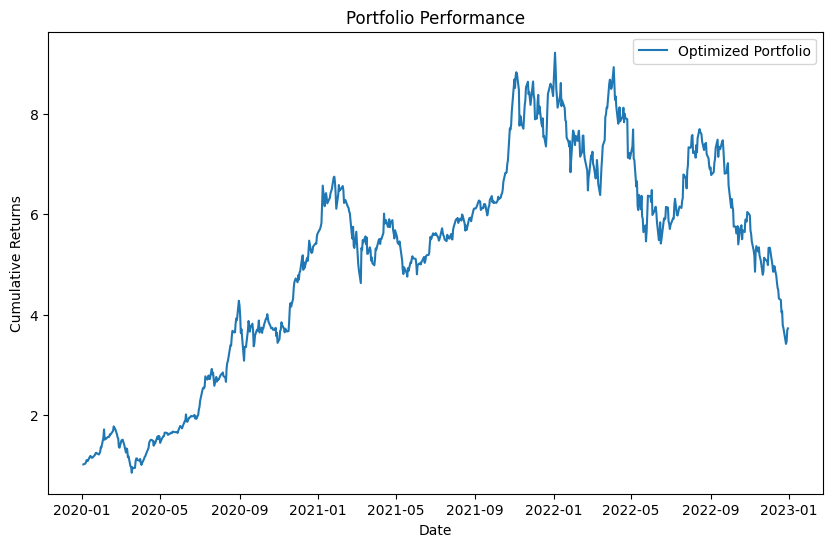

In [13]:
# Visualização dos resultados
def plot_portfolio_performance(data, weights, title='Portfolio Performance'):
    portfolio_returns = data.dot(weights)
    cumulative_returns = (1 + portfolio_returns).cumprod()
    plt.figure(figsize=(10, 6))
    plt.plot(cumulative_returns, label='Optimized Portfolio')
    plt.title(title)
    plt.xlabel('Date')
    plt.ylabel('Cumulative Returns')
    plt.legend()
    plt.show()

plot_portfolio_performance(returns, optimal_weights)

In [14]:
print("Optimal Weights:", optimal_weights)
print("Expected Annual Return:", opt_return)
print("Annual Volatility:", opt_std)
print("Sharpe Ratio:", opt_sharpe)
print("VaR 95%:", VaR_95)

Optimal Weights: [2.89582552e-01 1.64798730e-17 2.25514052e-17 6.07153217e-18
 7.10417448e-01]
Expected Annual Return: 0.6054425148161265
Annual Volatility: 0.5756896174685336
Sharpe Ratio: 1.0343117137224949
VaR 95%: Ticker
AAPL    -0.034843
AMZN    -0.037092
GOOGL   -0.035324
MSFT    -0.033384
TSLA    -0.068040
Name: 0.05, dtype: float64
